## DOMAIN OF THE DATA
<br>
 PPI network can be represented as a graph with a total of $\space n = 56944 \space$ nodes ( we split the data into two folds:    $\space n_{train} = 44906 \space$  and $\space n_{test} = 12038 \space$) 
 where each specific protein is identified with a node. 
 Furthermore each node is characterized with a <b>really sparse</b> binary feature 
 vector $\space x\in \{0,1\}^{50} \space$ and a list of undirected edges that explicits connections between nodes. 

In addition to the features, we have the labels  for the training set: a vector $l\in \{0,1\}^{122}$ for each node.
Our goal is to predict the labels of the test set with the best accuracy (F1 score will be evaluated). 
These are the data distributions:  


  1 | 2
 - | - 
![alt](./images/Training_set_features.png) | ![alt](./images/Training_set_feature_elements.png)

 3| 4 
 - | - 
![alt](./images/test_set_features.png) | ![alt](./images/Test_set_feature_elements.png)

5| 6 
 - | - 
![alt](./images/nlabels.png) | ![alt](./images/label_component.png)


'Feature10' ( which corresponds to the third element in the plot ) is costant to zero in each sample of the dataset and we delete it since it cannot express any causal correlation with the labels. Overall, the sparsity of the features suggests that we'll need to extract as much information as we can from graph structure.

As far as labels are concerned, we notice that they are quite dense. Moreover, if we assume the independence between label classes, applying the law of large numbers, we can esteem the mean of occurences of each class in the test set from its mean in the training set  ( this will come in handy at the end ). The plots 2 and 4 show the same result for the features.
<br>

In [6]:
import numpy as np
import utils  
from node2vec import Node2Vec  # NODE2VEC EMBEDDINGS 
import classifier as clf  # VERTEX CLASSIFIER
import matplotlib.pyplot as plt  # PLOTTING



<br>

### LOADING THE DATA

<br>
<div>
In the following section we define four foundamental matrices:
    
<br>
<ul>
    <li>$X_{train}\in \{0,1\}^{n_{train}\times49}$</li>
    <br>
    <li>$X_{test}\in \{0,1\}^{n_{test}\times49}$ </li>
    <br>
    <li>$X = \begin{bmatrix}X_{train} \\ X_{test}\end{bmatrix} \in \{0,1\}^{n\times49}$</li>
    <br>
    <li>$L\in \{0,1\}^{n\times122}$ 
 </li>
</ul>
</div>

In [8]:
# LOADING THE DATA
vertices_train, vertices_test = utils.build_vertices()

X_train_df = utils.build_dataframe(vertices_train, "feature")
X_train_df = X_train_df.drop(['feature_10'], axis=1)  # DROP USELESS FEATURE

X_test_df = utils.build_dataframe(vertices_test, "feature")
X_test_df = X_test_df.drop(['feature_10'], axis=1)  # DROP USELESS FEATURE

labels_df = utils.build_dataframe(vertices_train, "label", preserve_int_col_name=True)


# BUILDING NUMPY MATRICES 
X_train = X_train_df.values
X_test = X_test_df.values
X = np.concatenate((X_train, X_test), axis=0)
labels = labels_df.values

<br>
Here we define our graph  $\space G = (V,E)\space$ that represents the PPI network and we explicit all the edges.

<br>
<br>

Then we build our masks for training and test set :

<br>
    
<div>


<ul>
    <li>$idx_{train} =  \begin{pmatrix} 0,1\dots44905 \end{pmatrix} $</li>
    <br>
    <li>$idx_{test} = \begin{pmatrix} 44906,44907\dots56943 \end{pmatrix} $ </li>
    <br>
</ul>
</div>

In [ ]:
# MASK FOR TRAIN/TEST
train_idx = range(X_train.shape[0])
test_idx = range(X_train.shape[0],X.shape[0])

# BUILDING THE GRAPH
G = utils.build_graph() # ALSO REMOVES SELF-LOOPS
G = G.to_directed()  


<br>

## NODE2VEC


In our first approach we ignore the features matrix $\space X \space$ encoding each node with Node2Vec algorithm, using a definition of neighborhood as flexible as possible.

$ Node2Vec(G) \mapsto \mathbb{R}^{128} \space$ 

For every source node $u\in V$ , we define $\space N_{s}(u) \subset V\space$  as a network neighborhood of node $u$ generated through a sampling strategy $S$ described as follows:

given a source node $\space u\space$, we simulate a random walk of fixed length $\space l\space$. Let $\space c_{i}$ denote the $\space i_{th}\space$ node in the walk, starting with $c_{0} = u\space$. Nodes $\space c_{i} \space$ are generated with the following distribution: $\space P(c_{i} = x \mid c_{i-1}=v)  =   \begin{cases} 
      \frac{\pi_{vx}}{Z} & if \space(v,x) \in E \\
      0 & otherwise
   \end{cases}
$
where $\space \pi_{vx} \space$ is the unnormalized transition probability between nodes $\space v \space$ and $\space x \space$, and $\space Z \space$ is the normalizing constant. 

We consider a random walk that just traversed
edge $(t, v)$ and now resides at node $v$. The walk now needs to decide on the next step so it evaluates the transition probabilities $\pi_{vx}$ on edges $(v, x)$ leading from $v$. We set then the unnormalized transition probability to $\space \pi_{vx} =\alpha_{pq}(t, x)\cdot w_{vx}$, where $\space \alpha_{pq}(t, x) =  \begin{cases} 
      \frac{1}{p} & if \space d_{tx}=0 \\
       1 & if \space d_{tx}=1 \\
      \frac{1}{q} & if \space d_{tx}=2
   \end{cases}\space
$ and in our graph $\space w = 1 \space$ since the edges are unweighted. 


The use of two parameters $\space p \space$ and $\space q \space$ allowed us to combine in a single path breadth-first sampling and depth-first sampling. In particular the return parameter $\space p \space$  controls the likelihood of immediately revisiting a node in the walk while the parameter 'q' allows the search to differentiate between "inward" and "outward" nodes. Here we set $\space p = 1 \space$  and $\space q =5 \space$  biasing the walks close to node $\space t \space$ (BFS) in order to emphasize structural equivalence. We empirically choose the parameters taking into account the existence of connected components in the graph that might limit depth-first sampling.




![alt](./images/node2vec.jpg)

In [ ]:
# GENERATING WALKS OVER THE GRAPH
node2vec = Node2Vec(G, dimensions=128, walk_length=12, num_walks=10, p=1, q=5) 


<br>

#### SKIP-GRAM 

We proceed by applying the Skip-gram model. We seek to optimize the following objective function which maximizes the log-probability of observing a network neighborhood $\space N_{S}(u)\space$ for a node u conditioned on its encoded representation, given by f: 

$$
 \max_{f} \sum_{u \in V} \log P(N_{s}(u)\mid f(u)) $$

In order to make the optimization problem solvable we make two standard assumptions:

• Conditional independence. We factorize the likelihood by assuming that the probability of observing a neighborhood node given the embedding representation of the source node is independent of  seeing any other neighborhood node:

$$ P(N_{s}(u)\mid f(u)) = \prod_{n_{i} \in N_{s}(u)}P(n_{i} \mid f(u)) $$


• Symmetry in feature space. A source node and neighborhood node have a symmetric effect over each other in features space. 


Accordingly, we model the conditional likelihood of every source-neighborhood node pair as a softmax unit parametrized by a dot product of their embeddings:

$$P(n_{i} \mid f(u)) = \frac{\exp(\space f(n_{i}) \cdot f(u))}{\sum_{v \in V}\exp(f(v) \cdot f(u)} $$


With the above assumptions, the objective function simplifies to:

$$ \max_{f} \sum_{u \in V}\bigg[-\log Z_{u} + \sum_{n_{i} \in N_{s}(u)}f(n_{i} \cdot f(u)\bigg]$$

which is a simple optimization problem.

In [ ]:
# FITTING THE SKIP-GRAM MODEL
skipgram = node2vec.fit(window=8)


#  SAVING OUR EMBEDDINGS
embedding_n2v = skipgram[skipgram.wv.vocab]   
np.save('./embedding/embedding_n2v.npy', embedding_n2v)  # SAVING AS  A .NPY FILE


#### CLASSIFICATION 

Once we have mapped each node of the graph in a low-dimensional vector the task becomes a standard classification problem.

Since we don't use the feature matrices during the embedding phase now we concatenate the features with the embeddings ( here PCA is not necessary since the overall dimension is acceptable ).

Let's define our embeddings and our target matrix: 

<ul>
    <li>$\space E_{n2v} \in \mathbb{R}^{128}$</li>
    <br>
    <li>$ X_{n2v} = X \mid E_{n2v}$</li>
    <br>
</ul>


We use cross validation to avoid overfitting. Moreover, we consider  a weighted cross-entropy as loss function in order to balance the labels.

In [ ]:
# X MATRIX FOR CLASSIFICATION
train_embedding_n2v = embedding_n2v[train_idx]  # EXTRACTING TRAINING SET EMBEDDINGS
test_embedding_n2v = embedding_n2v[test_idx]  #  EXTRACTING TEST SET EMBEDDING
X_train_n2v = np.concatenate((X_train, train_embedding_n2v), axis=1)  #  FEATURES + EMBEDDING
X_test_n2v = np.concatenate((X_test, test_embedding_n2v), axis=1)  # FEATURES + EMBEDDINGS


#  TESTING VALIDATION ACCURACY
clf.validation_accuracy(X_train_n2v, labels)

#  TESTING TRAIN ACCURACY
node2vec_model = clf.fit_model(X_train_n2v, labels)  # RETURNS TRAINED MODEL AND TRAIN ACCURACY



#  MAKING PREDICTIONS
node2vec_pred = node2vec_model.predict_proba(X_test_n2v) > 0.5  # EVALUATING PREDICTIONS
node2vec_pred = utils.a_third_law(labels,node2vec_pred) 


utils.get_results('./results/node2vec_pred.csv',node2vec_pred, X_test_df)  # SAVING RESULTS IN A .CSV FOR KAGGLE



#### CONCLUSIONS ON NODE2VEC

The algorithm provides competitive performance on the embedding task but  an accuracy of $0.43/0.44$  is not enough to be considered good. We can do better!


<br>

## GRAPH CONVOLUTIONAL NETWORK

In the previous approach we didn't take advantage of the feature matrix to build the embeddings.
Now we aim to encode both graph structure and nodes' features in our embeddings using two graph convolutional networks. 

### GCN  ( Spectral Method )

<br>
Following the idea of T.N. Kipf and M.Welling, we directly encode the graph structure from its spectral representation using a semi-supervised neural network model $\space f(X, A) \space$ and then train on a supervised target for all nodes with labels.


In [ ]:
import torch
from gcn.model import GCN 
from train  import train_model 


We start with the extraction of the binary adjacency matrix $\space A \space$ from the graph; it is symmetric since the edges are undirected. <br>

Then we perform this operation  $\space \tilde{A} = A + \theta I \space$
to consider and set the importance of a node's own feature.

Let's define the degree matrix  as $\space \tilde{D} = \sum_{j}\tilde{A_{ij}}$, it will be useful for normalizing the feature representations. Indeed, a propagation rule without a normalization implies that nodes with larger degrees have larger values in their features while nodes with smaller degrees have smaller values.


In [188]:
# BUILDING ADJ MATRIX FOR GCN
A = utils.adjacency_matrix_GCN(G, theta=1)  


# DEFINING OUR PARAMETERS
n_features = X.shape[1]
n_classes = labels.shape[1]
n_hidden = 32  #  NUMBER OF HIDDEN PARAMETERS IN OUR NET


<br>

#### PROPAGATION RULE

The convolution operation on a graph is defined in the Fourier domain by computing the eigendecomposition of the graph Laplacian ( $\space \Delta = D - A\space$ ). Thanks to a truncated espansion in terms of Chebyshev polynomial of the convolution filter (approximation 1) and a constraint in the number of parameters (approximation 2), as showed in [this paper](https://arxiv.org/abs/1609.02907) by T.N. Kipf and M.Welling, we can define the propagation rule as follows:

$$\begin{cases} H^{(l+1)}=\sigma (\tilde{D}^{\frac{1}{2}}\tilde{A}\tilde{D}^{\frac{1}{2}}H^{(l)}W^{(l)}) \\
       H^{(0)}=X
   \end{cases}
$$
<br>

where $H^{(l)}$ are the hidden states.

Our goal is to obtain the best possible values of the weights matrix $\space W \space$ that minimize the cross entropy loss function. We reach this objective training our model with backpropagation.


After some trials and errors we set $2$ hidden layers with $16$ hidden parameters
(we found out that accuracy does not get better incrementing layers or parameters). 
The $2$ layers in our model are forcing each node to combine its features with his neighbors until the second order of proximity.

#### DROPOUT

In order to prevent the neural network from overfitting we apply a dropout rate of $0.5$. The key idea is to randomly drop units out of the neural network, along with their connections, during the training. 

![alt](./images/dropout.png)

In [ ]:
# CREATING AND TRAINING OUR MODEL

gcn_model = GCN(n_features, n_hidden, n_classes, dropout=0.5)
embedding_gcn = train_model(gcn_model, X, A, labels, train_idx, epochs=50, lr=0.005, wd=5e-3)


In [ ]:
#  EXTRACTING EMBEDDINGS 
train_embedding_gcn = embedding_gcn[train_idx]
test_embedding_gcn = embedding_gcn[test_idx]


#  TESTING TRAIN ACCURACY (SIGMOID TRESHOLD SET AT 0.4 )
gcn_train_pred = torch.sigmoid(train_embedding_gcn).detach().numpy() > 0.4 
utils.get_score(gcn_train_pred, labels)  # HAMMING ACCURACY, F1-MICRO, F1-MACRO

#  SAVING THE EMBEDDING
np.save('./embedding/embedding_gcn.npy', embedding_gcn.detach().numpy())  # .NPY FILE



In [12]:
#  MAKING OUR PREDICTION
gcn_test_pred = torch.sigmoid(test_embedding_gcn).detach().numpy() > 0.5  # PREDICTIONS ON TEST SET
gcn_test_pred = utils.a_third_law(labels,gcn_test_pred) # 0.475 accuracy
utils.get_results('./results/gcn_pred.csv',gcn_test_pred, X_test_df)  # SAVING RESULTS IN A .CSV 


Each embedding $ E \in \mathbb{R}^{122} $ . We can map it in $  \{0,1\}^{122}$ applying a  sigmoid function and then a  treshold.
 
As we expected, given the structural complexity of the GCN model, our accuracy increased.

However, the increase in accuracy is minimal and the score obtained is not enough.
We start wondering if our sparse features matrix $\space X \space$ contains enough information in order to perform this multi-label classification task.

Before jumping to conclusions we'll try to implement  GraphSAGE and GAT, other two state-of-the-art algorithms for this task.

In [13]:
from sage.model import SAGE


## GraphSAGE (spatial method)
  
Aiming to make our model richer and richer we implement now a second graph neural network called GraphSAGE. Unlike GCN, GraphSAGE is a spatial method with an <b> inductive </b> framework that does not consider spectral representation of the graph.
It's an inductive method because it doesn't need to retrain all the model from scratch for each new training example, as a consequence it can efficiently generates node embeddings for previously unseen data. 
Furthermore, it is a spatial (non-spectral) approach because it directly defines convolutions on the graph, operating on spatially close neighbors.

The intuition behind GraphSAGE is that at each iteration, nodes aggregate information from their local neighbors, and as this process iterates, nodes incrementally gain more and more information from further reaches of the graph.
At first, each node $\space v \in V \space$ aggregates the representations of the nodes in its immediate neighborhood, into a single vector. This aggregation step depends on the representations generated at the previous iteration of the outer loop (i.e., $\space k-1 \space$), and the $\space k = 0 \space$ representations are defined as the initial node features. 

After aggregating the neighboring feature vectors, GraphSAGE  concatenates the node’s current representation with the aggregated neighborhood vector, and this concatenated vector is fed through a fully connected layer with nonlinear activation function $\sigma$ .

We chose as aggregator function the element-wise mean aggreator.

This pseudo-code explains well all the steps:

![alt](./images/sage.jpg)


In [ ]:
#  CREATING THE MODEL
edge_list = torch.LongTensor(utils.edge_list_SAGE())  # list of all the edges
sage_model = SAGE(n_features, n_hidden, n_classes, 0.5)


#  TRAINING THE MODEL 
embedding_sage = train_model(sage_model, X, edge_list, labels, train_idx, epochs=25, lr=0.1,wd=5e-3)
sage_train_pred = torch.sigmoid(embedding_sage[train_idx]).detach().numpy() > 0.5# TRESHOLD ON SIGMOID PROBABILITIES
sage_train_pred = utils.a_third_law(labels,sage_train_pred)
utils.get_score(sage_train_pred, labels)  # HAMMING ACCURACY, F1-MICRO, F1-MACRO


#  SAVING THE EMBEDDING
np.save('./embedding/embedding_sage.npy', embedding_sage.detach().numpy())  # .NPY FILE


In [24]:
#  MAKING OUR PREDICTION
sage_test_pred = torch.sigmoid(embedding_sage[test_idx]).detach().numpy() > 0.5  # PREDICTIONS ON TEST SET
sage_test_pred = utils.a_third_law(labels,sage_test_pred) # BEST SAGE 0.477
utils.get_results('./results/sage_test_pred.csv',sage_test_pred, X_test_df)  # SAVING RESULTS IN A .CSV 


Once the aggregation function is defined we train the model as with GCN. Here the parameters that we want to train are the ones defining the AGGREGATE and CONCAT functions in the 4th and 5th line of Algorithm 1. Each embedding $ E \in \mathbb{R}^{122} $, we map it in $  \{0,1\}^{122}$ applying a  sigmoid function and then a  treshold.
 

Despite the efforts GraphSAGE performs with an accurancy between 0.44 and 0.46 on the test set, almost as the previous alghorithms. 

Before implementing GAT we'll try to combine the embedding methods we've seen so far in order to join their strenghts.
In doing so we don't want to enlarge the hypothesis space too much, therefore when we compose new node embeddings with doubled dimension we consider only the most relevant components.

In [ ]:
Y = np.concatenate((embedding_n2v,embedding_sage),axis=1)  # N2V EMBEDDING concatenated SAGE EMBEDDING
clf.validation_accuracy(Y[train_idx],labels)

In order to get a genuine accuracy from these concatenations we run a cross-validation on the training set. 

However both GraphSAGE$\mid$Node2Vec (roughly $0.425$ F1-Micro-Average) and  GCN$\mid$Node2Vec get worse accuracy than individual embeddings.



In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 64)
Y_pca = pca.fit_transform(Y)  #  250 --> 64
print('Explained variance: ',np.sum(pca.explained_variance_ratio_))  #  GOOD EXPLAINED VARIANCE
clf.validation_accuracy(Y_pca[train_idx],labels)     

Even the principal compenent analysis, that maps these new embeddings of  250 features in a low-dimensional space considering the 64 directions of maximum variance, does not improve our predictions. 
We also combine all the different models' predictions obtaining similar results.

## Graph Attention Network (GAT)

A last resort for our multi-label vertex classification problem is to implement GAT. Indeed, we read in  [this paper](https://arxiv.org/abs/1710.10903) that GAT can reach an accuracy of roughly $0.973$ on our protein-protein interactions network. 

In [8]:
from gat.ppi import PPI
from gat.model import GAT
from gat.training import train,test
from torch_geometric.data import DataLoader


Graph attention network is more sophisticated than previous graph neural networks. The idea is to compute the hidden representations of each node in the graph, by aggregating its neighbors under the rules of an  attention strategy. The attention architecture has several interesting properties: the operation is efficient, since it is parallelizable across node neighbors pairs and the model is directly applicable to inductive learning problems (as GraphSAGE), including tasks where the model has to generalize for completely unseen graphs.

In [9]:
#  LOADING DATASETS 
train_dataset = PPI('./gat',split='train')
test_dataset = PPI('./gat',split='test')
valid_dataset = PPI('./gat',split='valid')  #  LET'S KEEP SOME TRAINING SAMPLES FOR VALIDATION..


#  BATCH TRAINING.. 
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In order to obtain sufficient expressive power to transform the input features into higher-level features, as an initial step, we apply to every node a shared learnable linear transformation parametrized by a weight matrix:

$$z_i=W\vec{h_i} \quad \forall i=1,..,n$$

Then, a shared attentional mechanism $a$ computes attention coefficients that indicate the importance of node $j$'s features to node $i$:

$$e_{ij}=a(W\vec{h_i},W\vec{h_j})=LeakyReLU(\vec{a}^T(W\vec{h_i}||W\vec{h_j}) \quad\quad \forall i=1,..,n \quad \forall j\in N_i$$

This attention mechanism can be considered as generalization of the GCN  were  each node has not the same influence on its neighbors.  Indeed, we already introduced sort of an attention  coefficent in our model with the GCN $\theta$ parameter ( we added theta-times the identity matrix to the adjacency matrix to emphasize the importance of self-loops ).

To make coefficients easily comparable across different nodes, we normalize them across all choices of j using the softmax function:

$$ a_{ij}=softmax_j (e_{ij})=\frac {exp(e_{ij})}{\sum_{k \in N_i}exp(e_{ik})}=\frac {exp(LeakyReLU(\vec{a}^T(W\vec{h_i}||W\vec{h_j}))}{\sum_{k \in N_i}exp(LeakyReLU(\vec{a}^T(W\vec{h_i}||W\vec{h_k}))} \quad\quad \forall i=1,..,n \quad \forall j\in N_i$$

Once obtained, the normalized attention coefficients are used to compute a linear combination of their features. These will be the final output features for every node:

$$\vec{h'_i}=\sigma(\sum_{j\in N_i}a_{ij} W\vec{h_j}) \quad \forall i=1,..,n$$

To better stabilize the learning process we also extend the mechanism, implementing multi-head attention:

$$\vec{h'_i}=\parallel_{k=1}^{K} \sigma(\sum_{j\in N_i}a_{ij}^k W^k\vec{h_j}) \quad \forall i=1,..,n$$

In [ ]:
#  BUILDING AND TRAINING OUR MODEL
model = GAT(n_features,n_classes)
for epoch in range(1, 60):
    loss = train(model,train_loader) 
    acc = test(model,valid_loader) 
    print('Epoch: {:02d}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, loss, acc))

For the learning task, we apply a three-layer GAT model. Both of the first two layers consist of K = 4 attention heads computing F0 = 256 features, followed by an ELU nonlinearity. The final layer is used for (multi-label) classification:
K = 6 attention heads, each computing 122 features that are averaged and followed by a logistic sigmoid activation.


In order to improve even more the accuracy, with some  statistical considerations we impose  the most probable classes of labels to 1 without taking into account our prediction. This 'trick' improves our score of $0.02$.

In [17]:
#  MAKING PREDICTIONS
model.cpu()
for data in test_loader:    
    out = model(data.x,data.edge_index)
    
pred = out.float().cpu() > 0
pred = utils.a_third_law(labels,pred)

utils.get_results('./results/gat_pred.csv',pred, X_test_df)  # SAVING RESULTS IN A .CSV 

Oooooooo... 0.5207!!! This is our best score  but again.. it is not so good. Is it possible to reach the same F1 score reported in the paper? It turns out that our dataset is a bit different.

Graph and labels are the same but features are different: instead of being binary, their features matrix  $ X \in [0,1]^{50}$ (it's continuos not discrete). Therefore, we guess that our features matrix is the paper's matrix activated with a non-liner function (probabily a simple step function). <br><br>
Eventually, we can set our mind at rest: <b>our data does not contain enough information in order to reach a good accuracy</b>. 
However, this doesn't mean that all the embeddings we have built are useless: each one is a simpler structure where we store in a better way the sparse informations of the dataset.


To emphasize how bad are our predictions, we now present our simple statistical algorithm that obtains almost the same accuracy as GAT and considers only the labels.



### (NAIVE) STATISTICAL APPROACH

We want to obtain the best accuracy possible basing our predictions only on  statistical considerations about labels' distribution. 
With this data we cannot predict the probability of a node to have a $1$ in a single element of its label. 

We don't want to randomly build  our predictions, therefore given a label class out of the $122$ we have to decide if it is set to $1$ or to $0$ for all the nodes in the test set.<br>

To  decide if a given class should be $0$ or $1$ we define a vector $L_{mean}\in [0,1]^{122}$ as follows:<br><br>
$$ L_{mean}(i) = \frac{\mid\{v\mid L_{v,i}=1\}\mid}{n_{train}}$$ <br>
$L_{mean}$ rapresents the mean of each label class in the training set. In the very beginning, we observed  that for the law of large numbers, each one of these values should tend to the same mean in the test set. 

In [11]:
lmean = utils.get_lmean(labels)    
lmean = utils.sort_lmean(lmean)  #  DESCENDING ORDER 

The idea is to force $1$ to a number $s$ of label classes $i$ if $L_{mean}(i)$ is 'big enough'. We need to  define what 'big enough' actually means. 

We reorder the element of $L_{mean}$ from the biggest to the smallest and then evaluate $V(s)$, an  approximation of $F1$.

$$V(s) = 2\cdot \frac {\sum_{i=1}^{s} L_{mean}(i)}{\sum_{i=1}^{122} L_{mean}(i) + n_{train}\cdot s} \simeq F1(s)$$

The variable $s$  goes from $1$ to $122$ and expresses the number of activated classes, starting with the one with bigger mean in the training set. 

In [13]:
A = 0
k = 0
f1_values = np.zeros(lmean.shape[0])
for i in range(lmean.shape[0]):
    k += lmean[i][0]
for s in range(lmean.shape[0]):
    A += lmean[s][0]
    f1 = 2 * A / (k+X_train.shape[0]*(s+1))
    f1_values[s] = f1
    

Evaluating the function $V$ in all his domain $\{1,2,...,122\}$ and considering its maximum we find the value of $s$ that maximize our strategy and an esteem of its relative F1 score:<br>
$$s_{max}=57$$ <br>
$$V(s_{max})=0.527$$ <br>
The following plot rapresents the trend of $V(s)$.

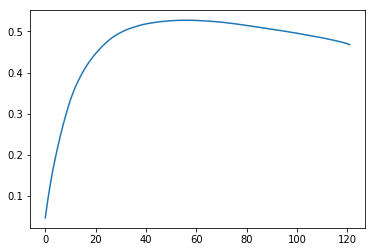

In [20]:
%matplotlib inline
plt.plot(f1_values)

In [ ]:
mask = lmean_f[:np.argmax(f1_values),1]
pred = np.zeros((X_test.shape[0],labels.shape[1]))

for col in range(labels.shape[1]):
    for i in range(np.argmax(f1_values)):
        if(mask[i] == col):
            pred[:,col] =1 
            
utils.get_results('./results/stat.csv',pred, X_test_df)  # SAVING RESULTS IN A .CSV  

We obtain an accuracy of $0.485$ on the test set which is in line with our esteem.

On this dataset, <b> our 'naive' algorithm is more accurate than  GCN, Node2Vec,GraphSAGE </b> and their concatenations as far as vertex classification is concerned. Furthermore, it predicts a constant label for each element in the test set without taking into account graph or features. 

This result allows us to  emphasize a last important conlusion: <br>

<b>$$Machine\space Learning\space is\space not\space magic!$$</b>

If data is not good enough, we can't pretend flawless performance even from the best machine learning algorithm for that specific task. In this specific case, statistic alone performes better than state-of-the-art algorithms that are not able learn from the data.
